#### Network analysis on the interactions between users of r\WallStreetBets
In this notebook, a directed graph will be constructed from the interactions between people posting on the subreddit and the people commenting on them.
Later, some general statistics on the graph will be computed, followed by an authority vs hub analysis and a thorough visualization.

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
data = pd.read_pickle('post_comments')

In [13]:
df = pd.DataFrame(data, 
                  columns=['post_id', 'post_user', 'comment_id', 'comment_user'])
df

,post_id,post_user,comment_id,comment_user
0,gmxhbfi,Humble_Signature_993,lb255a,arauz7
1,gmpsv32,spookybonez,lb255a,arauz7
2,gmpmko6,nobuouematsu1,lb255a,arauz7
3,gmpkjo2,Shigx,lb255a,arauz7
4,gmm6dhx,hastorow,lb255a,arauz7
...,...,...,...,...
4113927,glmqpiy,Awkward_Battle_723,laabwm,trevor1400E
4113928,glmqiik,YouKnow-TheFarmer,laabwm,trevor1400E
4113929,glmqgz5,iwouldificouldbitch,laabwm,trevor1400E
4113930,glmqefv,ianjustinferris,laabwm,trevor1400E


In [17]:
df_new = df.groupby(['post_user', 'comment_user']).size().reset_index()

In [21]:
df_new['weight'] = df_new[0]
df_new = df_new.drop(columns=[0])
df_new

,post_user,comment_user,weight
0,---------II---------,Inevita92,1
1,---------II---------,eidorianc,1
2,---------II---------,only1parkjisung,1
3,------TooyBooy------,bobfreehuman,1
4,------what------,jaymancini,1
...,...,...,...
2039741,zzzzzz129,grebfar,5
2039742,zzzzzz129,theycallme1,2
2039743,zzzzzz129,wallstreetboyfriend,3
2039744,zzzzzzzzzzzzzqqqqqqq,DunderMuggler,1


In [23]:
G = nx.from_pandas_edgelist(df_new, source='comment_user', target='post_user', 
                            edge_attr='weight', create_using=nx.DiGraph())

In [24]:
G.number_of_nodes() 

637395

In [25]:
G.number_of_edges()

2039746

In [27]:
N, K = G.number_of_nodes() , G.number_of_edges()
avg_deg = float(K) / N
avg_deg

3.200128648640168

In [34]:
in_degrees = list(G.in_degree()) # dictionary node:degree
in_values = sorted(set([in_degree[1] for in_degree in in_degrees]))
in_hist = [[in_degree[1] for in_degree in in_degrees].count(x) for x in in_values]

<ipython-input-40-f372c9d95eaf>:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 2*10**2])


(0.6188500645217611, 200)

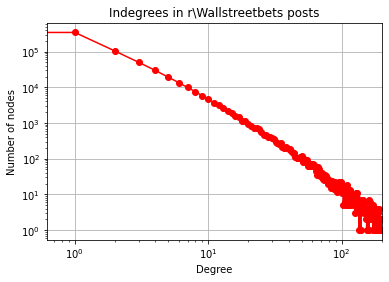

In [40]:
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.loglog(in_values, in_hist, 'ro-') # in-degree
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Indegrees in r\Wallstreetbets posts')
plt.xlim([0, 2*10**2])

In [49]:
G_ud = G.to_undirected()
#print(nx.average_clustering(G_ud))

In [ ]:
# Connected components are sorted in descending order of their size
G_mc = max(nx.connected_components(G_ud), key=len)
G_S = G_ud.subgraph(G_mc).copy()
# Betweenness centrality
bet_cen = nx.betweenness_centrality(G_S)
# Closeness centrality
clo_cen = nx.closeness_centrality(G_S)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(G_S)

In [ ]:
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x[0], items[:top])

In [ ]:
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cent = get_top_keys(eig_cen,10)

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G))
sorted(c[0])

In [ ]:
from networkx.algorithms.link_analysis.hits_alg import hits
h, a = nx.hits(G)
a

In [ ]:
from networkx.algorithms.reciprocity import overall_reciprocity
rec = overall_reciprocity(G)
rec

In [ ]:
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
len_shortest = nx.average_shortest_path_length(G)